In [1]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import datetime as dt
import math
import datetime
from datetime import timedelta
from pandas.plotting import autocorrelation_plot

from sklearn.preprocessing import MinMaxScaler
from IPython.display import Image
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller

pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore") # specify to ignore warning messages
os.chdir('C:\\Users\\omkarp\\Downloads\\python_KTH\\')

In [2]:
df = pd.read_excel('01_Urine.xlsx')
df.head()

,Kategori,Date,SynpunktCommonWord,DpFeatureType,Koordinater_X,Koordinater_Y,count,factor
0,Felanmälan,2019-01-01,Hundbajs,Städning,"155,547.43","6,581,386.53",1,1
1,Felanmälan,2019-01-02,Avföring,Städning,"151,737.55","6,579,691.77",1,1
2,Felanmälan,2019-01-02,Hundbajs,Städning,"149,147.06","6,578,444.97",1,1
3,Felanmälan,2019-01-03,Avföring,Städning,"153,229.72","6,579,763.47",1,1
4,Klagomål,2019-01-04,Offentliga toaletter,Offentliga toaletter,"151,740.81","6,577,807.09",1,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3353 entries, 0 to 3352
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Kategori            3353 non-null   object        
 1   Date                3353 non-null   datetime64[ns]
 2   SynpunktCommonWord  3353 non-null   object        
 3   DpFeatureType       3353 non-null   object        
 4   Koordinater_X       3353 non-null   float64       
 5   Koordinater_Y       3353 non-null   float64       
 6   count               3353 non-null   int64         
 7   factor              3353 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 209.7+ KB


In [4]:
df = df.groupby(["Date","SynpunktCommonWord", "DpFeatureType","Koordinater_X","Koordinater_Y"]).size().reset_index(name="count")
df = df.drop(columns = ["SynpunktCommonWord", "DpFeatureType","Koordinater_X", "Koordinater_Y"])
df.sort_values(by=['Date'], ignore_index= True)
df = df.groupby(["Date"]).size().reset_index(name="count")
df = df.reset_index(drop=True).dropna()
df.rename(columns={'count':'Incidents'}, inplace=True)
df.head()

,Date,Incidents
0,2019-01-01,1
1,2019-01-02,2
2,2019-01-03,1
3,2019-01-04,1
4,2019-01-05,1


In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df=df.groupby(['Date'])['Incidents'].sum().reset_index()
df.head()

,Date,Incidents
0,2019-01-01,1
1,2019-01-02,2
2,2019-01-03,1
3,2019-01-04,1
4,2019-01-05,1


In [6]:
df=df.set_index('Date')
df.head()

,Incidents
Date,
2019-01-01,1
2019-01-02,2
2019-01-03,1
2019-01-04,1
2019-01-05,1


In [7]:
from datetime import date, timedelta
sdate = date(2019,1,1)   # start date
edate = date(2021,6,5)   # end date #date(2021,6,5)

pd.date_range(sdate,edate-timedelta(days=1),freq='d')
s=[sdate+timedelta(days=x) for x in range((edate-sdate).days)]
df3 = pd.DataFrame(s)
df3=df3.rename(columns={0:'Date'})
df3=df3.set_index('Date')
df3['Incidents'] = df['Incidents']
df3=df3.fillna(0)
df3.head()

,Incidents
Date,
2019-01-01,1.00
2019-01-02,2.00
2019-01-03,1.00
2019-01-04,1.00
2019-01-05,1.00


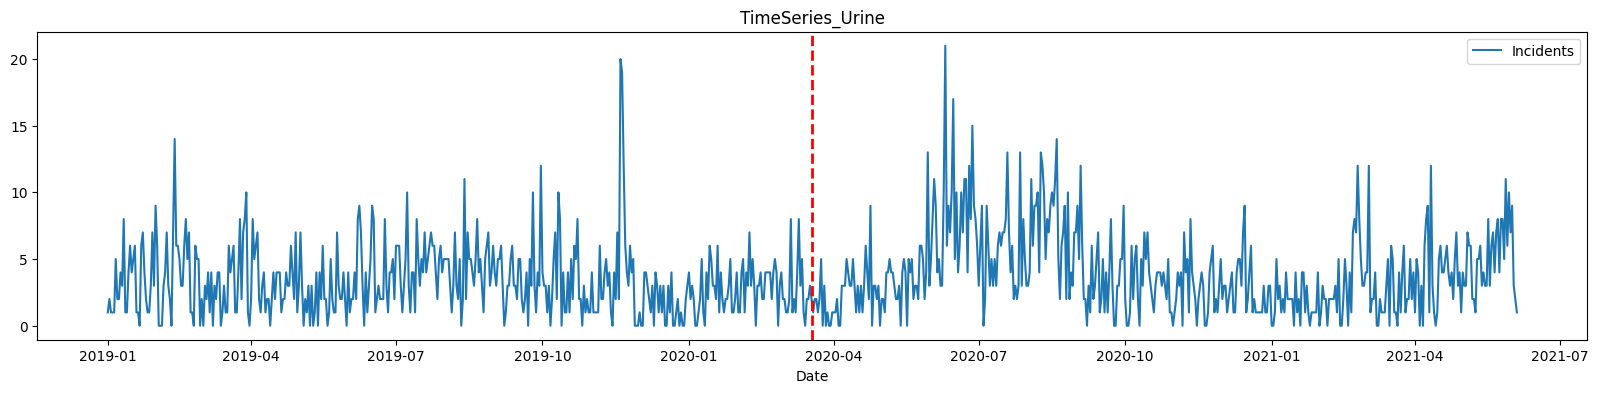

In [8]:
df=df3
fig, ax = plt.subplots(figsize=(20, 4))
#plt.figure(figsize=(20,4))
df[['Incidents']].plot(ax = plt.gca())
ax.axvline(pd.to_datetime('2020-03-18 00:00:00'), color='r', linestyle='--', lw=2)
plt.title("TimeSeries_Urine")
#plt.savefig('C:/Users/ogpci/Desktop/Vegetation.png')
plt.show()

In [9]:
df=df.reset_index()
df.head()

,Date,Incidents
0,2019-01-01,1.00
1,2019-01-02,2.00
2,2019-01-03,1.00
3,2019-01-04,1.00
4,2019-01-05,1.00


In [10]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.query('"2019-01-01 00:00:00" <= Date < "2021-06-06 00:00:00"')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 886 entries, 0 to 885
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       886 non-null    datetime64[ns]
 1   Incidents  886 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 20.8 KB


In [11]:
# Format Date column as a datetime object
df['Date'] = pd.to_datetime(df['Date'])
# Make a column for the date of the start of the week
df['Week_Start'] = df['Date'].dt.to_period('W').apply(lambda x: x.start_time)

# Make a column with the date for the Week End
df['Week_End'] = df['Week_Start'] + timedelta(days=6)
df['Week_Number'] = df['Date'].dt.week
df.head()

,Date,Incidents,Week_Start,Week_End,Week_Number
0,2019-01-01,1.00,2018-12-31,2019-01-06,1
1,2019-01-02,2.00,2018-12-31,2019-01-06,1
2,2019-01-03,1.00,2018-12-31,2019-01-06,1
3,2019-01-04,1.00,2018-12-31,2019-01-06,1
4,2019-01-05,1.00,2018-12-31,2019-01-06,1


In [12]:
Alldata = df.groupby(['Week_Number','Week_End'])['Incidents'].sum().reset_index()
Alldata.rename(columns={'Week_End':'Date','Incidents':'Incidents'}, inplace=True)
Alldata.head()

,Week_Number,Date,Incidents
0,1,2019-01-06,11.00
1,1,2020-01-05,16.00
2,1,2021-01-10,18.00
3,2,2019-01-13,21.00
4,2,2020-01-12,13.00


In [13]:
df = Alldata.sort_values(by='Date',ascending=True).reset_index(drop=True)
df.rename(columns={'Week_Number':'Week'}, inplace=True)
df.head()

,Week,Date,Incidents
0,1,2019-01-06,11.00
1,2,2019-01-13,21.00
2,3,2019-01-20,27.00
3,4,2019-01-27,21.00
4,5,2019-02-03,28.00


In [14]:
df.drop(columns={'Week'}, inplace=True)
df= df.set_index('Date')
df.head()

,Incidents
Date,
2019-01-06,11.00
2019-01-13,21.00
2019-01-20,27.00
2019-01-27,21.00
2019-02-03,28.00


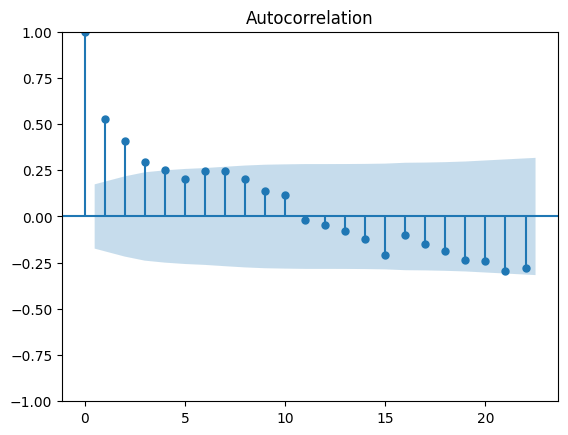

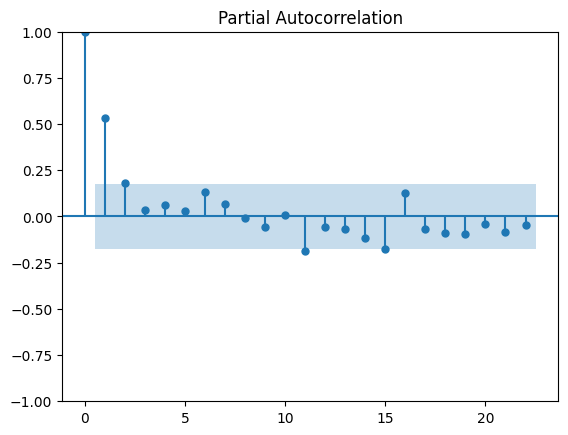

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df)
plt.show()
plot_pacf(df)
plt.show()

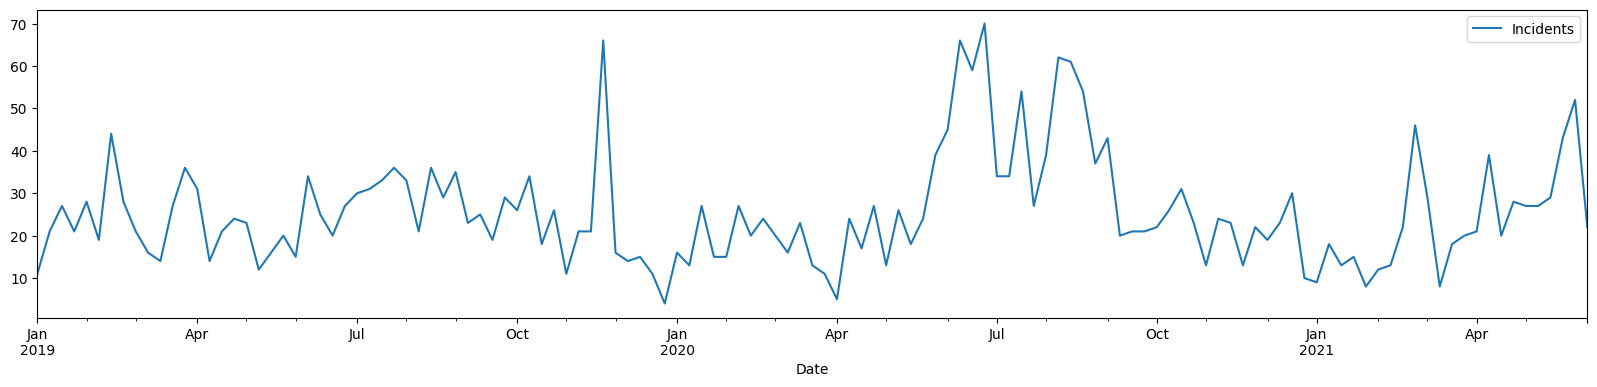

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,4))
df[['Incidents']].plot(ax = plt.gca())
ax.axvline(pd.to_datetime('2019-07-18'), color='r', linestyle='--', lw=2)
plt.show()

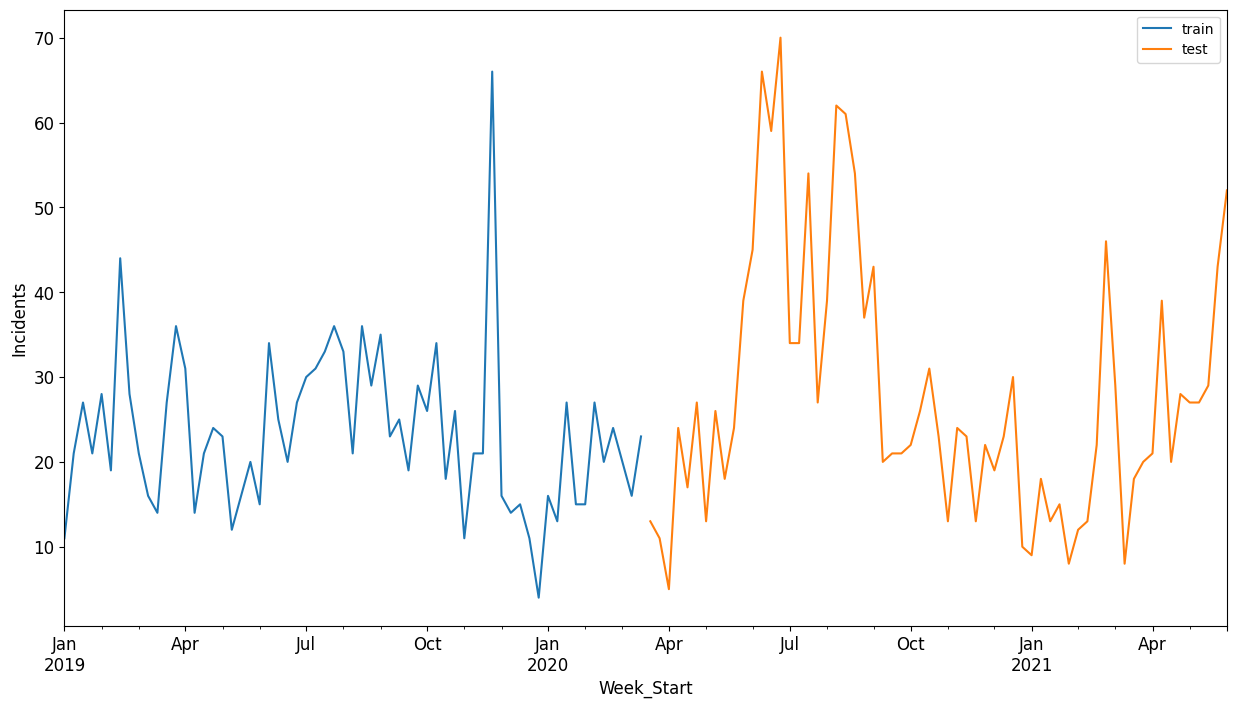

In [17]:
train_start_dt = '2019-01-01 00:00:00'
test_start_dt = '2020-03-19 00:00:00'  
Alldata = df.query('"2019-01-01 00:00:00" < Date < "2021-06-05 00:00:00"')
#Alldata=Alldata.set_index('Date')
Alldata[(Alldata.index < test_start_dt) & (Alldata.index >= train_start_dt)][['Incidents']].rename(columns={'Incidents':'train'}) \
    .join(Alldata[test_start_dt:][['Incidents']].rename(columns={'Incidents':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('Week_Start', fontsize=12)
plt.ylabel('Incidents', fontsize=12)
#plt.savefig('C:/Users/ogpci/Desktop/1.png')
plt.show()

In [18]:
train = Alldata.copy()[(Alldata.index >= train_start_dt) & (Alldata.index < test_start_dt)][['Incidents']]
test = Alldata.copy()[Alldata.index >= test_start_dt][['Incidents']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (63, 1)
Test data shape:  (63, 1)


In [19]:
scaler = MinMaxScaler()
train['Incidents'] = scaler.fit_transform(train)
train.head()

,Incidents
Date,
2019-01-06,0.11
2019-01-13,0.27
2019-01-20,0.37
2019-01-27,0.27
2019-02-03,0.39


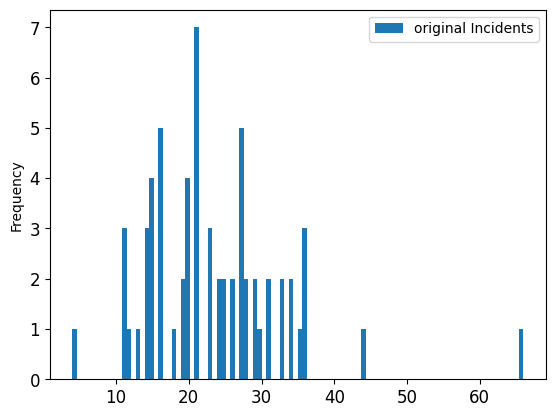

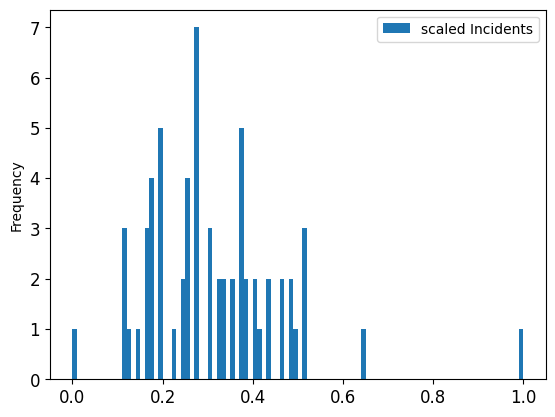

In [20]:
Alldata[(Alldata.index >= train_start_dt) & (Alldata.index < test_start_dt)][['Incidents']].rename(columns={'Incidents':'original Incidents'}).plot.hist(bins=100, fontsize=12)
train.rename(columns={'Incidents':'scaled Incidents'}).plot.hist(bins=100, fontsize=12)
plt.show()

In [21]:
test['Incidents'] = scaler.transform(test)
test.head()

,Incidents
Date,
2020-03-22,0.15
2020-03-29,0.11
2020-04-05,0.02
2020-04-12,0.32
2020-04-19,0.21


Forecasting horizon: 4 hours


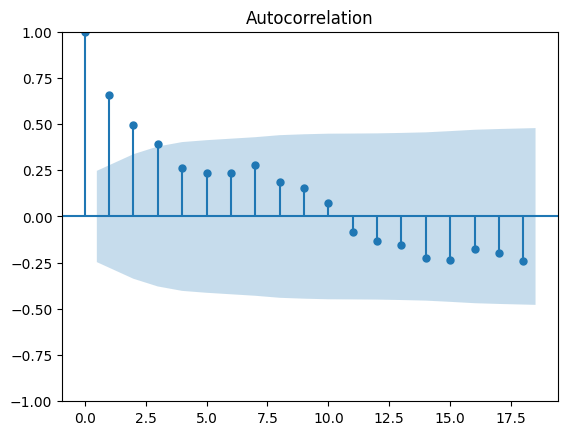

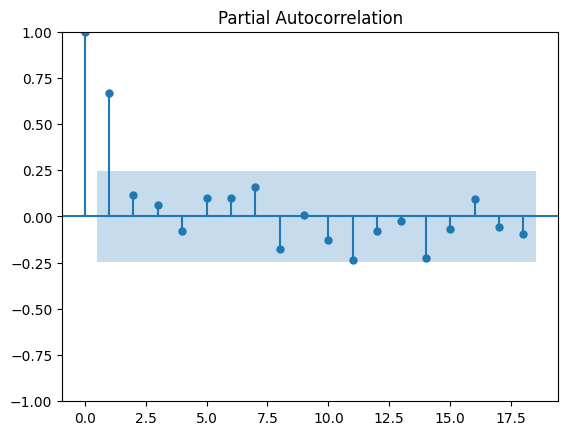

In [22]:
# Specify the number of steps to forecast ahead
HORIZON = 4
print('Forecasting horizon:', HORIZON, 'hours')

plot_acf(test)
plt.show()
plot_pacf(test)
plt.show()

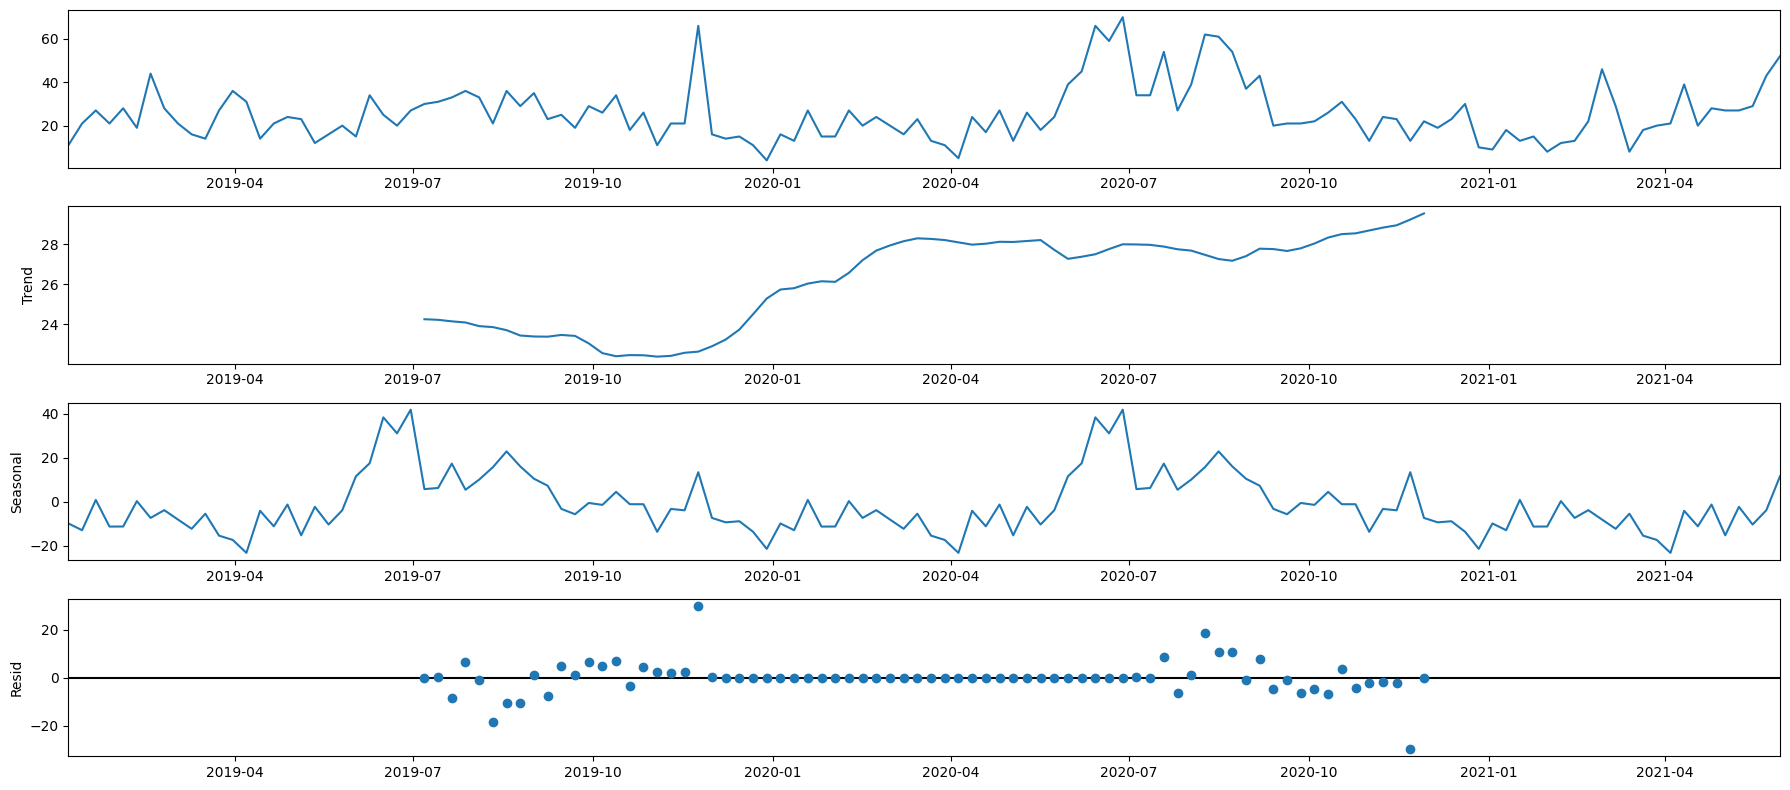

In [23]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(Alldata)
fig = decomposition.plot()
plt.show()

In [24]:
order = (4, 1, 0)
seasonal_order = (1, 1, 0, 6)

model = SARIMAX(endog=train, order=order, seasonal_order=seasonal_order)
results = model.fit()

print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                         Incidents   No. Observations:                   63
Model:             SARIMAX(4, 1, 0)x(1, 1, 0, 6)   Log Likelihood                   9.383
Date:                           Wed, 17 May 2023   AIC                             -6.766
Time:                                   13:53:58   BIC                              5.386
Sample:                               01-06-2019   HQIC                            -2.055
                                    - 03-15-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5926      0.155     -3.835      0.000      -0.895      -0.290
ar.L2         -0.4212      0.171     -2.463

In [25]:
test_shifted = test.copy()
test_shifted.head()

,Incidents
Date,
2020-03-22,0.15
2020-03-29,0.11
2020-04-05,0.02
2020-04-12,0.32
2020-04-19,0.21


In [26]:
for t in range(1, HORIZON): test_shifted['Incidents+'+str(t)] = test_shifted['Incidents'].shift(-t, freq='W')
test_shifted = test_shifted.dropna(how='any')
test_shifted.head()

,Incidents,Incidents+1,Incidents+2,Incidents+3
Date,,,,
2020-03-22,0.15,0.11,0.02,0.32
2020-03-29,0.11,0.02,0.32,0.21
2020-04-05,0.02,0.32,0.21,0.37
2020-04-12,0.32,0.21,0.37,0.15
2020-04-19,0.21,0.37,0.15,0.35


In [27]:
test_shifted=test_shifted.fillna(0.01)
test_shifted.tail()

,Incidents,Incidents+1,Incidents+2,Incidents+3
Date,,,,
2021-04-11,0.56,0.26,0.39,0.37
2021-04-18,0.26,0.39,0.37,0.37
2021-04-25,0.39,0.37,0.37,0.40
2021-05-02,0.37,0.37,0.40,0.63
2021-05-09,0.37,0.40,0.63,0.77


In [28]:
%%time
training_window = 720 # dedicate 30 days (720 hours) for training

train_ts = train['Incidents']
test_ts = test_shifted

history = [x for x in train_ts]
history = history[(-training_window):]

predictions = list()

# let's user simpler model for demonstration
order = (2, 1, 0)
seasonal_order = (1, 1, 0, 24)

for t in range(test_ts.shape[0]):
    model = SARIMAX(endog=history, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    yhat = model_fit.forecast(steps = HORIZON)
    predictions.append(yhat)
    obs = list(test_ts.iloc[t])
    # move the training window
    history.append(obs[0])
    history.pop(0)
    print(test_ts.index[t])
    print(t+1, ': predicted =', yhat, 'expected =', obs)

2020-03-22 00:00:00
1 : predicted = [0.26 0.36 0.25 0.19] expected = [0.14516129032258063, 0.11290322580645162, 0.016129032258064516, 0.3225806451612903]
2020-03-29 00:00:00
2 : predicted = [0.3  0.18 0.11 0.07] expected = [0.11290322580645162, 0.016129032258064516, 0.3225806451612903, 0.2096774193548387]
2020-04-05 00:00:00
3 : predicted = [ 0.09 -0.   -0.04  0.06] expected = [0.016129032258064516, 0.3225806451612903, 0.2096774193548387, 0.3709677419354839]
2020-04-12 00:00:00
4 : predicted = [-0.04 -0.09  0.01 -0.04] expected = [0.3225806451612903, 0.2096774193548387, 0.3709677419354839, 0.14516129032258063]
2020-04-19 00:00:00
5 : predicted = [0.08 0.22 0.19 0.7 ] expected = [0.2096774193548387, 0.3709677419354839, 0.14516129032258063, 0.3548387096774193]
2020-04-26 00:00:00
6 : predicted = [0.29 0.27 0.78 0.31] expected = [0.3709677419354839, 0.14516129032258063, 0.3548387096774193, 0.2258064516129032]
2020-05-03 00:00:00
7 : predicted = [0.32 0.87 0.35 0.29] expected = [0.14516129

2021-04-11 00:00:00
56 : predicted = [0.35 0.18 0.32 0.47] expected = [0.564516129032258, 0.25806451612903225, 0.3870967741935484, 0.3709677419354839]
2021-04-18 00:00:00
57 : predicted = [0.34 0.44 0.62 0.63] expected = [0.25806451612903225, 0.3870967741935484, 0.3709677419354839, 0.3709677419354839]
2021-04-25 00:00:00
58 : predicted = [0.38 0.57 0.56 0.82] expected = [0.3870967741935484, 0.3709677419354839, 0.3709677419354839, 0.4032258064516129]
2021-05-02 00:00:00
59 : predicted = [0.57 0.55 0.81 0.72] expected = [0.3709677419354839, 0.3709677419354839, 0.4032258064516129, 0.629032258064516]
2021-05-09 00:00:00
60 : predicted = [0.39 0.66 0.56 0.69] expected = [0.3709677419354839, 0.4032258064516129, 0.629032258064516, 0.7741935483870968]
CPU times: total: 1min 44s
Wall time: 47.8 s


In [29]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test.index[0:len(test.index)-HORIZON+1]
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.array(np.transpose(test_ts)).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

,timestamp,h,prediction,actual
0,2020-03-22,t+1,20.31,13.00
1,2020-03-29,t+1,22.39,11.00
2,2020-04-05,t+1,9.49,5.00
3,2020-04-12,t+1,1.61,24.00
4,2020-04-19,t+1,8.76,17.00


In [30]:
if(HORIZON > 1):
    eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
    print(eval_df.groupby('h')['APE'].mean())

h
t+1   0.58
t+2   0.73
t+3   0.75
t+4   0.71
Name: APE, dtype: float64


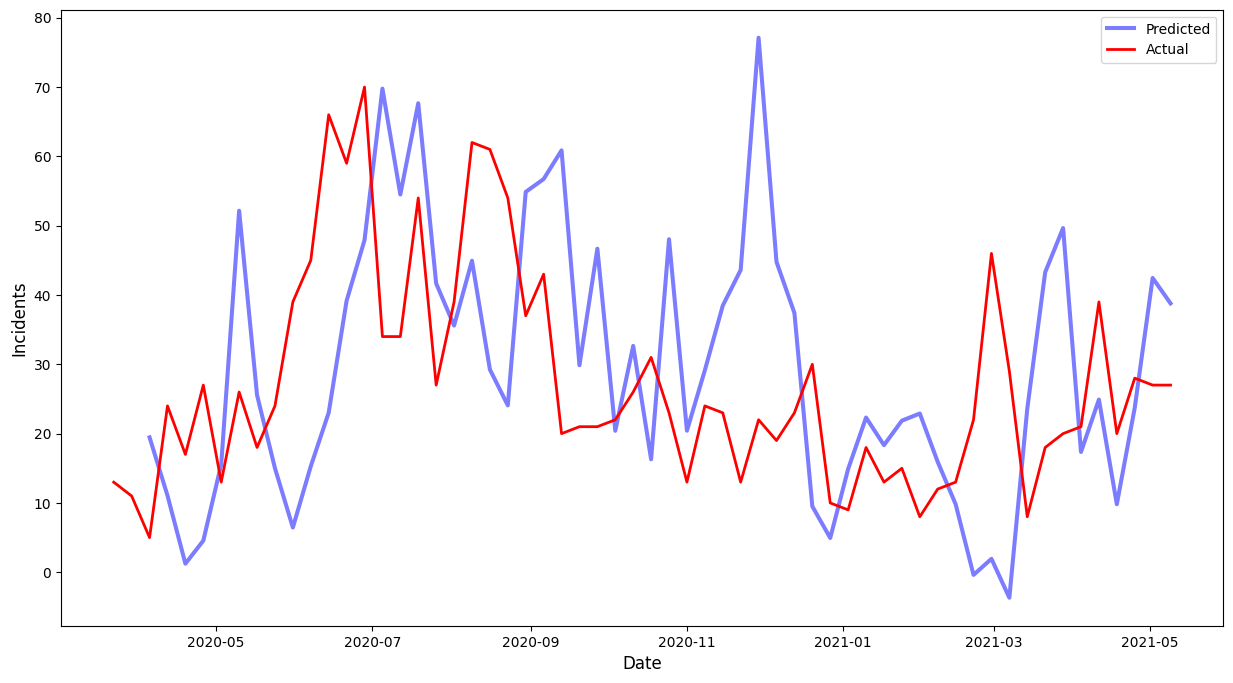

In [31]:
if(HORIZON == 1):
    ## Plotting single step forecast
    eval_df.plot(x='timestamp', y=['actual', 'prediction'], style=['r', 'b'], figsize=(15, 8))

else:
    ## Plotting multi step forecast
    plot_df = eval_df[(eval_df.h=='t+1')][['timestamp', 'actual']]
    for t in range(3, HORIZON):
        plot_df['t+'+str(t)] = eval_df[(eval_df.h=='t+'+str(t))]['prediction'].values

    fig = plt.figure(figsize=(15, 8))
    
    ax = fig.add_subplot(111)
    for t in range(3, HORIZON):
        x = plot_df['timestamp'][(t-1):]
        y = plot_df['t+'+str(t)][0:len(x)]
        ax.plot(x, y, color='blue', linewidth=4*math.pow(.9,t), alpha=math.pow(0.8,t))
    ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=2.0)
    
    
plt.xlabel('Date', fontsize=12)
plt.ylabel('Incidents', fontsize=12)
plt.legend(["Predicted", "Actual"], loc=0)
#plt.savefig('C:/Users/ogpci/Desktop/1.png')
plt.show()

In [32]:
eval_df.tail()

,timestamp,h,prediction,actual,APE
235,2021-04-11,t+4,33.29,27.00,0.23
236,2021-04-18,t+4,42.87,27.00,0.59
237,2021-04-25,t+4,55.01,29.00,0.90
238,2021-05-02,t+4,48.84,43.00,0.14
239,2021-05-09,t+4,46.60,52.00,0.10


# Plotting predictions with confidence intervals

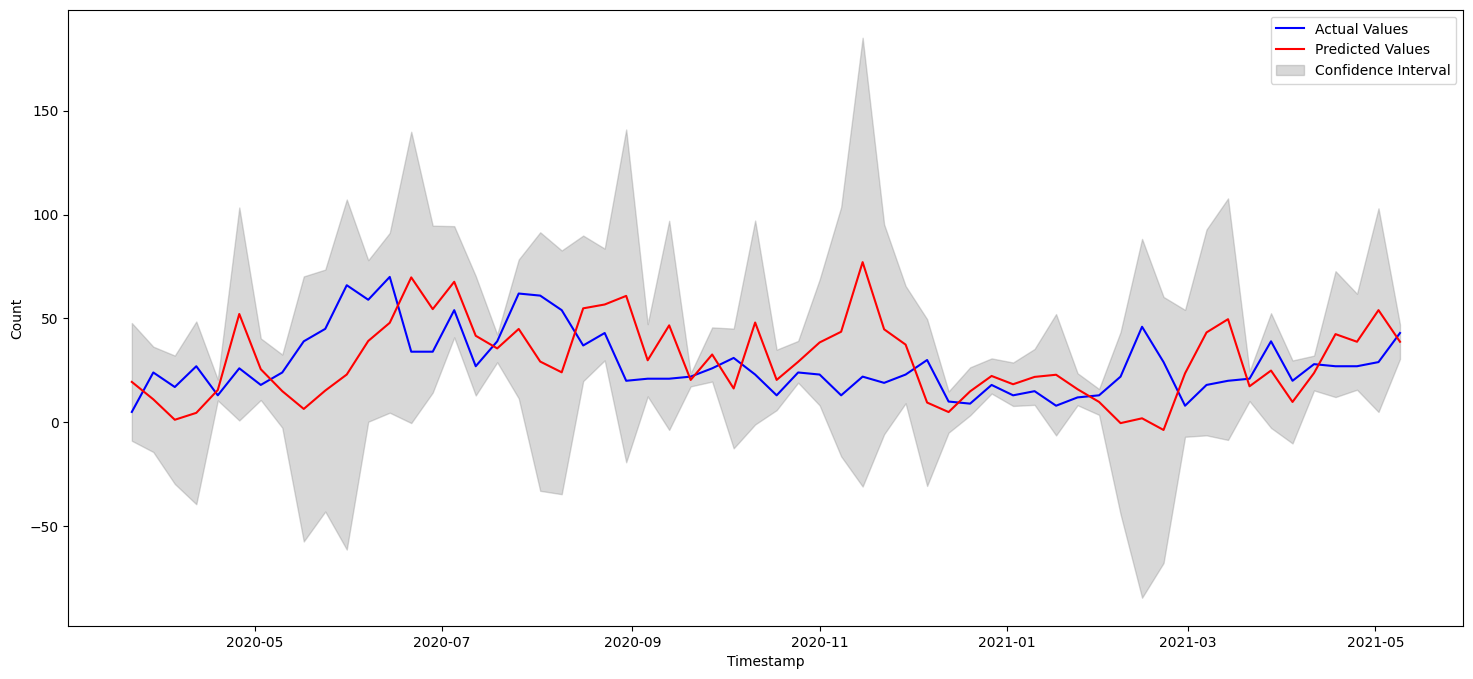

In [33]:
df = eval_df[eval_df['h'] == 't+3']
# Create a figure and axis for the plot
fig, ax = plt.subplots()
# Plot the actual values as a blue line
ax.plot(df['timestamp'], df['actual'], color='blue', label='Actual Values')

# Plot the predicted values as a red line
ax.plot(df['timestamp'], df['prediction'], color='red', label='Predicted Values')

# Calculate and plot the confidence interval as a shaded region
y_upper = df['prediction'] + 1.96 * df['APE'] * df['actual']
y_lower = df['prediction'] - 1.96 * df['APE'] * df['actual']
ax.fill_between(df['timestamp'], y_lower, y_upper, color='gray', alpha=0.3, label='Confidence Interval')

# Add a legend and axis labels
ax.legend()
ax.set_xlabel('Timestamp')
ax.set_ylabel('Count')

# Display the plot
plt.show()

# Prediction metrics

In [34]:
from sklearn.metrics import mean_absolute_percentage_error
Y_actual = eval_df['actual']
Y_Predicted = eval_df['prediction']
print('MAPE: ', mean_absolute_percentage_error(Y_actual, Y_Predicted))

MAPE:  0.6938916875219202


In [35]:
# Root Mean Squared Error (RMSE)
y_actual = eval_df['actual']
y_predicted = eval_df['prediction']
RMSE = math.sqrt(np.square(np.subtract(y_actual,y_predicted)).mean())
print("Root Mean Square Error:", RMSE)

Root Mean Square Error: 19.805686757554042


In [36]:
#Symmetric Mean Absolute Percentage Error (sMAPE)
A = eval_df['actual']
F = eval_df['prediction']
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

print(smape(A, F))

60.19645987570594
